# A simple state-and-transition model of urban development

This is a very, very simple implementation of a state-and-transition model (STM), applied to a developing city. This model can be thought of as a kind of a cellular automata or agent-based model (ABM). We start with an initial spatial map of a city with wild/undeveloped pixels (0s) and urban/developed pixels (1s). These initial conditions can be thought of as a kind of agent. And at each time step, undeveloped agents evaluate the "urbanness" of a square region around them. Based on how developed that environment is they are less or more likely to switch to being developed; the less urban the neighborhood the less likely the pixel will flip. The more urban the more likely. But even when a neighborhood surrounding an undeveloped pixel is very urbanized the transition probability is still pretty low (we can set it, but a transition probability of 6% would be high). Also, we're assuming that urbanization is a non-reversible process. That is, once a pixel is developed or urban, there's no going back. This is a very simple toy model that's essentially meant to show how state and transition models work, and how in an ABM an agent can incorporate some degree of interaction with neighboring agents when making a decision. In this case, an undeveloped agent "asks" how many of her/his neighbors are developed pixels and then increasing the likelihood of transitioning from undeveloped to developed. 

In [2]:
# For an iPython Notebook, show figures in line
%matplotlib inline 

# Import important libraries
import numpy as np
import matplotlib.pyplot as plt
import math as m

import warnings
warnings.filterwarnings('ignore')

In [3]:
Ntime = 100 # Number of time steps to run (years)

## Parameters controlling a "neighborhood" search

Now we define a few parameters that control how we decide whether an undeveloped or pixel will "flip" to being developed. Essentially, we will look in a square region (neighborhood) around a pixel and determine how many of those pixels are urbanized. The probability of flipping - or transition probability - increases from a minimum of zero when the percentage of developed pixels is zero in the neighborhood to a maximum value above some threshold of neighborhood urbanization. The shape of that increase is a logistic curve and we set a critical neighborhood urbanization percentage where the logistic function is half it's maximum value.

In [4]:
Ring = 6 # Number of rings of cells to evaluate neighborhood

# Set Transition probabilities
P_WU_lonely  = 0.00 # The Wild-to-Urban transition probability when the neighborhood is 100% wild
P_WU_crowded = 0.10 # The Wild-to-Urban transition probability when the neighborhood is 100% urban
f_UrbanCrit  = 0.50 # A value of neighborhood urban percentage where the logistic function 
                    # is (P_WU_lonely + P_WU_crowded)/2
k_logistic   = 10.0 # The steepness of the logistics function increase

## Load the initial conditions
The intitial condition is something I created in excel and isn't anywhere in particular, nor does it necessarily adhere to any interesting properties of real developed areas (i.e., roughness, fractal dimensions, etc. aren't real). Also, spatial dimensions are completely arbitrary. This could be relatively small towns in very high resolution, or it could be megapolitan cities in coarser detail.

(-0.5, 285.5, 298.5, -0.5)

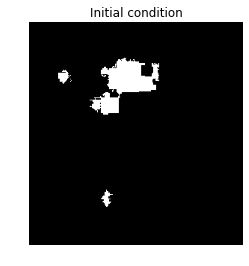

In [5]:
# Load the initial city map
CityMap = np.load('InitialCity.npy') # Load the initial condition from 
CityMapInit = np.copy(CityMap) # Clone the initial condition 

# Plot the initial condition for show
plt.figure(1)
plt.imshow(CityMapInit,cmap='gray')
plt.title("Initial condition")
plt.axis('off')

## The main loop
The cell below presents the guts of the program. Effectively we loop through every time step. Within each time step, we loop through each pixel of the domain. At that pixel, we ask whether it's developed (==1) or not (==0). If it's not (again, we're assuming that once a pixel becomes developed, there's no going back), then we query to see how developed the nearby surrounding neighborhood is. Based on the fraction/percentage of urbanization we then calculate a transition probability. The more developed that surrounding neighborhood, the higher that transition probability. Then we flip a coin (or, more accurately generate a uniform random number on a 0-1 interval). If the generated random number is less than that transition probability the pixel switches from being undeveloped to being developed. If not, then it remains undeveloped. 

In [6]:
dims = np.shape(CityMap) # Get the dimensions of the spatial domain
Nrows = dims[0] # Get the number of rows
Ncols = dims[1] # Get the number of columns

for i in xrange(0,Ntime):
    
    # Copy the map of the city. We don't want transitions from wild to urban 
    # within a time loop to influence the potential transition of adjoining pixels
    # pixels in the nearby neighborhood.
    CityMapUpdated = np.copy(CityMap)     

    for j in xrange(0,Nrows):
        
        for k in xrange(0,Ncols):
            
            if(CityMap[j,k] == 0.0): # Only need to consider wild pixels
                
                # Get the starting and ending row and column numbers N=Ring pixels 
                # in the each direction of the pixel in question (the neighborhood)
                StartRow = np.max((j-Ring-1,0))
                EndRow   = np.min((j+Ring+1,Nrows-1))
                StartCol = np.max((k-Ring-1,0))
                EndCol   = np.min((k+Ring+1,Ncols-1))
                
                # Get the 1s and 0s of the surrounding neighborhood
                HoodMap = CityMap[StartRow:EndRow,StartCol:EndCol]

                # Get the fraction of urbanized pixels in the neighborhood
                dimsHoodMap = np.shape(HoodMap)
                NHoodPix = float(dimsHoodMap[0]*dimsHoodMap[1])
                NHoodUrb = np.sum(HoodMap)
                
                # Compute the fraction of pixels in the neighborhood that are urbanized/developed
                f_Urban = NHoodUrb/NHoodPix
                
                # Get the urbanization weighted transition probability
                # Transform neighborhood fraction and the critical fraction to a value that ranges from 
                # -infinity to +infinity so that we can use the full range of the logistic function
                g_Urban = np.tan((f_Urban - 0.5)*m.pi)
                g_UrbanCrit = np.tan((f_UrbanCrit - 0.5)*m.pi)
                
                # Compute the transition probability for this particular pixel
                P_WU = P_WU_crowded / (1 + np.exp(-k_logistic*(float(g_Urban - g_UrbanCrit)))) + P_WU_lonely
                
                # Now here is where our transition decision gets made 
                if(np.random.uniform() < P_WU): # Transition if true
                    CityMapUpdated[j,k] = 1.0   # Now urbanized
                    
    # At the end of the time loop, store the updated map for the next time step
    CityMap = np.copy(CityMapUpdated)
    
    # Print out our progress to the command line
    print "Completed time step " + format(i) + ". " + format(float(i+1)/float(Ntime)*100.0) + "% complete"


Completed time step 0. 1.0% complete
Completed time step 1. 2.0% complete
Completed time step 2. 3.0% complete
Completed time step 3. 4.0% complete
Completed time step 4. 5.0% complete
Completed time step 5. 6.0% complete
Completed time step 6. 7.0% complete
Completed time step 7. 8.0% complete
Completed time step 8. 9.0% complete
Completed time step 9. 10.0% complete
Completed time step 10. 11.0% complete
Completed time step 11. 12.0% complete
Completed time step 12. 13.0% complete
Completed time step 13. 14.0% complete
Completed time step 14. 15.0% complete
Completed time step 15. 16.0% complete
Completed time step 16. 17.0% complete
Completed time step 17. 18.0% complete
Completed time step 18. 19.0% complete
Completed time step 19. 20.0% complete
Completed time step 20. 21.0% complete
Completed time step 21. 22.0% complete
Completed time step 22. 23.0% complete
Completed time step 23. 24.0% complete
Completed time step 24. 25.0% complete
Completed time step 25. 26.0% complete
Compl

## Plot up the results
In the following figures we plot the initial and final maps, as well as the change between the beginning and end of the simulation. In the change map, blue pixels are pixels that remain undeveloped, red pixels are those that were initially urban, and white pixels are pixels that began as wild and transition to urban during the course of the simulation.

(-0.5, 285.5, 298.5, -0.5)

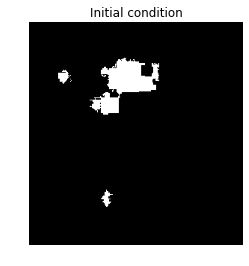

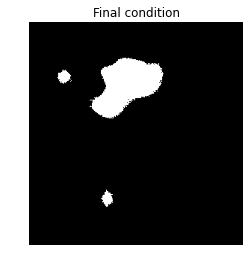

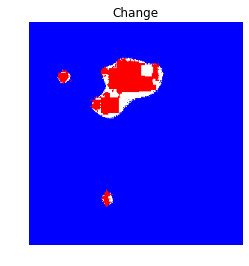

In [8]:
# Make some plots
plt.figure(2)
plt.imshow(CityMapInit,cmap='gray')
plt.title("Initial condition")
plt.axis('off')

plt.figure(3)
plt.imshow(CityMap,cmap='gray')
plt.title("Final condition")
plt.axis('off')

plt.figure(4)
plt.imshow(CityMap+CityMapInit,cmap='bwr')
plt.title("Change")
plt.axis('off')
